## Axisymmetric Pendant Drop Shape Analysis (ADSA) for Surface Tension Measurement

This notebook demonstrates the measurement of surface tension from geometric parameters of a pendant drop by analyzing its captured image and fitting the Young-Laplace equation to the experimentally obtained droplet profile.

<a href="https://ibb.co/d4bx5c0L"><img src="https://i.ibb.co/k23vSyg9/Sessile.png" alt="Sessile" border="0"></a><br />|

### Physical Background

A pendant drop at static equilibrium is governed by the balance between gravitational forces and surface tension. This equilibrium state is mathematically described by the **Young-Laplace equation**, which relates the shape of the drop to the forces acting upon it.

### Governing Equations

The theoretical profile of the pendant drop is obtained by solving the following set of ordinary differential equations (ODEs):

\begin{equation}
\frac{d\varphi}{d\tilde{s}} = 2 + Bo \cdot \tilde{z} - \frac{\sin(\varphi)}{\tilde{x}}
\tag{1}
\end{equation}

\begin{equation}
\frac{d\tilde{x}}{d\tilde{s}} = \cos(\varphi)
\tag{2}
\end{equation}

\begin{equation}
\frac{d\tilde{z}}{d\tilde{s}} = \sin(\varphi)
\tag{3}
\end{equation}

Where:

- $\varphi$ is the angle between the tangent to the drop profile and the horizontal axis.
- $\tilde{x}$ and $\tilde{z}$ are dimensionless coordinates normalized by the drop curvature at the apex.
- $\tilde{s}$ is the dimensionless arc length along the drop profile.
- $Bo$ is the Bond number, which characterizes the ratio of gravitational to surface tension forces.

By solving these equations and fitting the resulting theoretical profile to the experimental image, the surface tension can be accurately determined.

# Import the Libraries

In [93]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, feature, measure
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares
from scipy.interpolate import interp1d
import pandas as pd
from scipy.interpolate import CubicSpline
import glob
import os
import cv2
from skimage import io, transform

## Define Inputs

In [96]:
apex_detection = 0.15 # it is used to detect apex point by fitting a circle selecting percentage of points starting from apex advised value is 0.15
image_file_location = 'Sample_Imgs' # change based on location of your file
image_file_extension = '*.png' # change based on image extension
# The drop should be cropped starting from a few pixels above the solid liquid contact line
num_drop = 0 # the first image in your file in png extension you can change based on the image you want to analyse
px_to_mm = 1/306.25 # The scale ratio

# Load the image

In [99]:
image_path = os.path.join(image_file_location, image_file_extension)
images = glob.glob(image_path)

for image in images: 
    print (image)
    
image = io.imread(images[0])

Sample_Imgs\IMG_7830.png
Sample_Imgs\IMG_7831.png


# Display the images

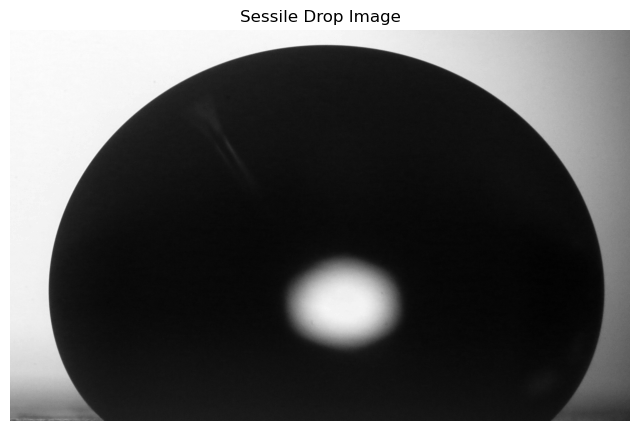

In [102]:
plt.figure(figsize=(8, 6))  # Set the figure size
plt.imshow(image, cmap='gray')  # Use 'gray' if the image is grayscale
plt.axis('off')  # Hide axis for better visualization
plt.title("Sessile Drop Image")
plt.show()

# Apply Canny edge detection

In [105]:
edges = feature.canny(image, sigma=2)
# Extract X and Y coordinates of edge points
y_coords, x_coords = np.nonzero(edges)

# Plot the original image and the detected edges

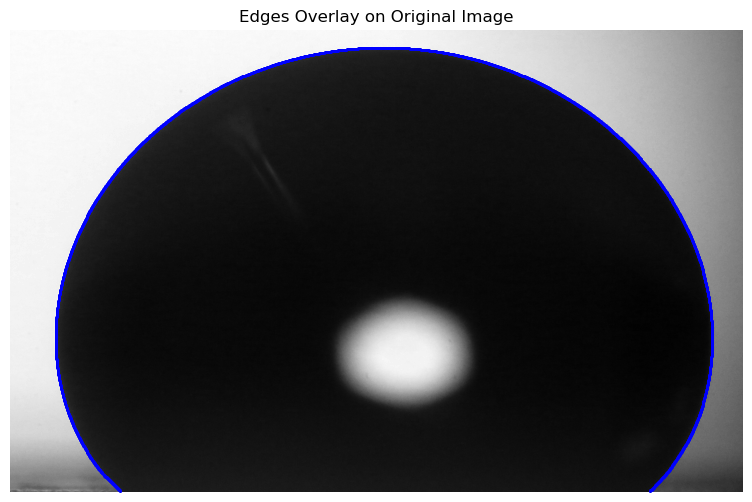

In [108]:
# Plot the original grayscale image with filtered edges overlaid
plt.figure(figsize=(10, 6))
plt.imshow(image, cmap='gray')  # Show original image
plt.scatter(x_coords, y_coords, s=1, color='blue')  # Overlay edges
plt.title("Edges Overlay on Original Image")
plt.axis("off")
plt.show()

## Filter the detected edges to get only the drop edges

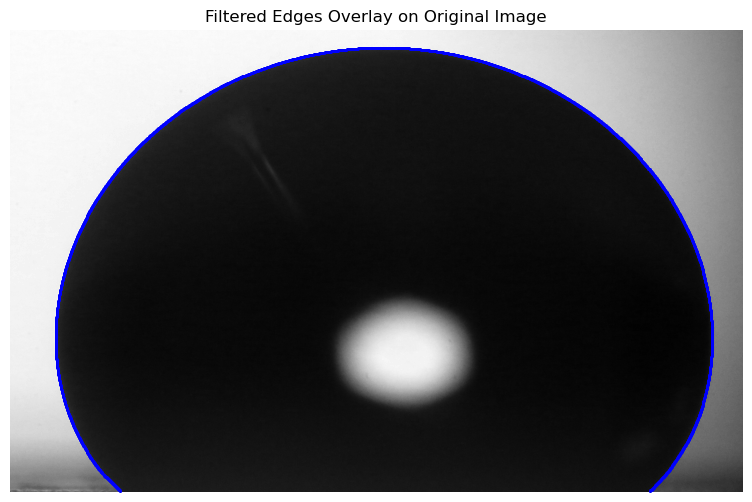

In [111]:
# Label connected components (to filter out noise)
labeled_edges = measure.label(edges)
regions = measure.regionprops(labeled_edges)

# Find the largest connected component (assumed to be the drop)
largest_region = max(regions, key=lambda r: r.area)

# Create a mask to keep only the largest contour
filtered_edges = np.zeros_like(edges)
filtered_edges[labeled_edges == largest_region.label] = 1

# Extract X and Y coordinates of the filtered edge points
edges = filtered_edges
y_coords, x_coords = np.nonzero(edges)

# Plot the original grayscale image with filtered edges overlaid
plt.figure(figsize=(10, 6))
plt.imshow(image, cmap='gray')  # Show original image
plt.scatter(x_coords, y_coords, s=1, color='blue')  # Overlay edges
plt.title("Filtered Edges Overlay on Original Image")
plt.axis("off")
plt.show()

# Convert px into mm 

In [114]:
X_matrix = x_coords.reshape(-1, 1) * px_to_mm
Y_matrix = -y_coords.reshape(-1, 1) * px_to_mm

# Find the symmetry axis

Vertical Range (max_y - min_y): 901
Fitted Circle Center: (758.84, 779.93)
Fitted Circle Radius: 744.22


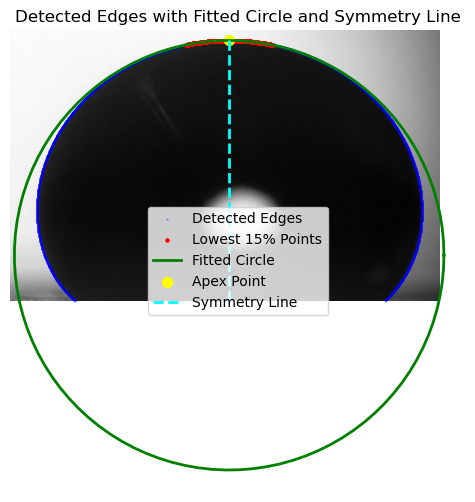

Apex coordinates: (758.84, 35.71)


In [117]:
# Step 1: Compute vertical range
max_y = np.max(y_coords)   # in px
min_y = np.min(y_coords)
y_range = max_y - min_y
print(f"Vertical Range (max_y - min_y): {y_range}")

# Step 2: Select the lowest 15% of points
num_points = len(y_coords)
num_selected = int(0.90 * num_points)  # Select 15% of lowest points

# Sort indices by y-coordinates (ascending order)
sorted_indices = np.argsort(y_coords)[::-1]
lowest_15_indices = sorted_indices[num_selected:]

# Get the lowest 15% of points
x_lowest = x_coords[lowest_15_indices]
y_lowest = y_coords[lowest_15_indices]

# Step 3: Fit a circle to these points
def circle_residuals(params, x, y):
    xc, yc, r = params
    return np.sqrt((x - xc) ** 2 + (y - yc) ** 2) - r

# Initial guess for circle center and radius
x_mean, y_mean = np.mean(x_lowest), np.mean(y_lowest)
r_guess = np.mean(np.sqrt((x_lowest - x_mean) ** 2 + (y_lowest - y_mean) ** 2))
initial_guess = [x_mean, y_mean, r_guess]

# Perform least squares fitting
result = least_squares(circle_residuals, initial_guess, args=(x_lowest, y_lowest))
xc, yc, r_fitted = result.x  # Extract fitted circle parameters

# Generate circle points for plotting
theta = np.linspace(0, 2 * np.pi, 100)
circle_x = xc + r_fitted * np.cos(theta)
circle_y = yc + r_fitted * np.sin(theta)

# Print fitted circle parameters
print(f"Fitted Circle Center: ({xc:.2f}, {yc:.2f})")
print(f"Fitted Circle Radius: {r_fitted:.2f}")

# Compute the apex point of the drop
apex_x = xc  # The apex shares the same x-coordinate as the fitted circle's center
apex_y = yc - r_fitted  # Subtract radius in the y-direction

# Define the symmetry line from apex to the top of the image
symmetry_line_x = [apex_x, apex_x]  # Vertical line at the apex x-coordinate
symmetry_line_y = [apex_y, max_y]  # From apex to the top of the image

# Plot detected edges, fitted circle, and symmetry line
plt.figure(figsize=(10, 6))
plt.imshow(image, cmap='gray')  # Show original image
plt.scatter(x_coords, y_coords, s=0.05, color='blue', label="Detected Edges")  # Overlay edges
plt.scatter(x_lowest, y_lowest, s=5, color='red', label="Lowest 15% Points")  # Highlight lowest 15% points
plt.plot(circle_x, circle_y, color='green', linewidth=2, label="Fitted Circle")  # Overlay fitted circle
plt.scatter(apex_x, apex_y, color='yellow', s=50, label="Apex Point")  # Mark the apex
plt.plot(symmetry_line_x, symmetry_line_y, color='cyan', linestyle='--', linewidth=2, label="Symmetry Line")  # Draw symmetry line
plt.title("Detected Edges with Fitted Circle and Symmetry Line")
plt.axis("off")
plt.legend()
plt.show()

# Return the apex coordinates
print(f"Apex coordinates: ({apex_x:.2f}, {apex_y :.2f})")

## Shift the matrices respect to apex

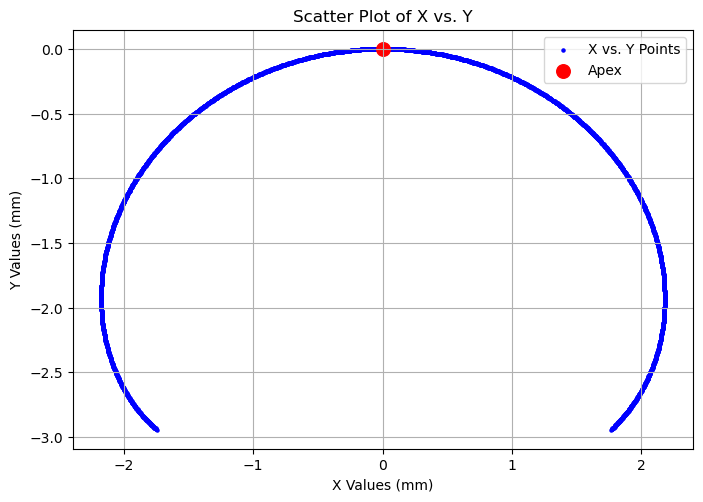

In [120]:
apex_x = apex_x * px_to_mm
apex_y = apex_y  * px_to_mm
X_matrix -= apex_x
Y_matrix += apex_y

plt.figure(figsize=(8, 6))
plt.scatter(X_matrix, Y_matrix, color='blue', s=5, label="X vs. Y Points")
plt.xlabel("X Values (mm)")
plt.ylabel("Y Values (mm)")
plt.title("Scatter Plot of X vs. Y")
plt.gca().set_aspect('equal')   # set aspect ratio equal
plt.scatter(0, 0, s=95, color='red', label="Apex")  # Overlay edgesplt.legend()
plt.legend()
plt.grid(True)
plt.show()


## Take average of left and right side of the drop to get y(x) function

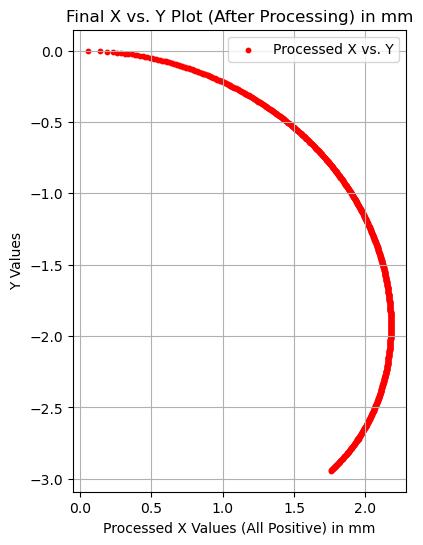

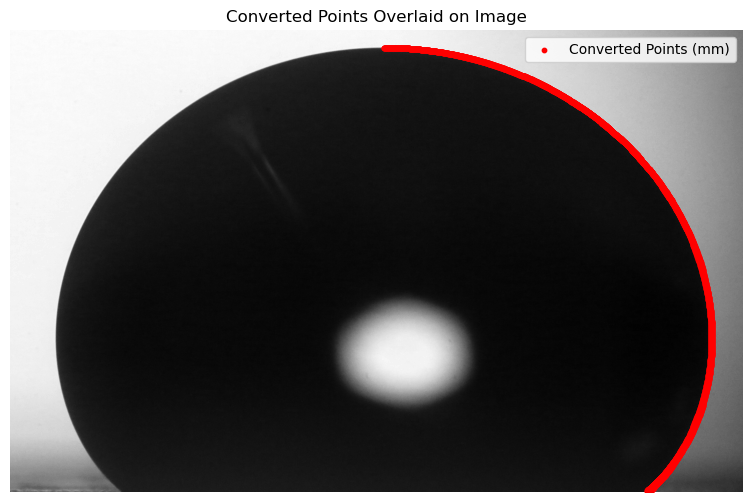

In [126]:
# Convert X_matrix to absolute values (Step 1)
X_matrix = np.abs(X_matrix)  # Ensure all x-values are positive

# Step 2: Process X_matrix to keep only one x-value per unique y
unique_y_values = np.unique(Y_matrix)
final_x_values = []
final_y_values = []

for y in unique_y_values:
    indices = np.where(Y_matrix == y)[0]  # Get indices where y matches
    x_values = X_matrix[indices]  # Get corresponding x values

    avg_x = np.mean(x_values)  # Average the x values (even if there's only one)
    
    final_x_values.append(avg_x)  # Store the single x for this y
    final_y_values.append(y)  # Store the corresponding y

# Convert to numpy arrays for plotting
final_x_values = np.array(final_x_values)
final_y_values = np.array(final_y_values)

# Step 3: Plot the processed X vs. Y
plt.figure(figsize=(8, 6))
plt.scatter(final_x_values, final_y_values, color='red', s=10, label="Processed X vs. Y")
plt.xlabel("Processed X Values (All Positive) in mm")
plt.ylabel("Y Values")
plt.title("Final X vs. Y Plot (After Processing) in mm")
plt.gca().set_aspect('equal')   # set aspect ratio equal
plt.legend()
plt.grid(True)
plt.show()

apex_x_px = apex_x / px_to_mm
apex_y_px = apex_y  / px_to_mm

# Create new matrices: convert pixel coordinates to mm
X_matrix_px = X_matrix / px_to_mm
Y_matrix_px = Y_matrix / px_to_mm * -1
X_matrix_px += apex_x_px
Y_matrix_px += apex_y_px

# Plot the imported image and overlay the converted points
plt.figure(figsize=(10, 6))
plt.imshow(image, cmap='gray')
plt.scatter(X_matrix_px, Y_matrix_px, color='red', s=10, label="Converted Points (mm)")
plt.title("Converted Points Overlaid on Image")
plt.axis("off")
plt.legend()
plt.show()


## Use least mean square method to get surface tension

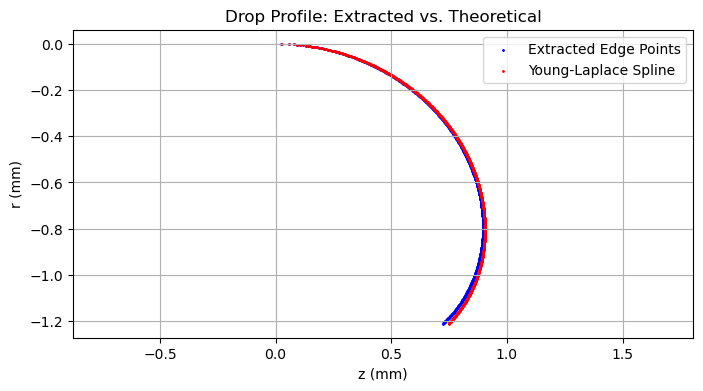

In [142]:
def young_laplace(s, y, Bo):
    u, r, z = y
    du_ds = 2 + Bo * z - np.sin(u) / r
    dr_ds = np.cos(u)
    dz_ds = np.sin(u)
    return [du_ds, dr_ds, dz_ds]

def compute_theoretical_r_profile(R0, Gamma, z_arr):  # evaluate only for z_arr, returns r_arr
    g = 9.81  # Gravity in m/s²
    rho = 997 # Density of liquid in kg/m³
    
    # Compute Bond number
    Bo = (rho * g * R0**2) / Gamma
    
    # Initial conditions at drop apex
    u0 = 1e-6  # Tangent angle in radians
    r0 = 1e-6  # Small nonzero initial radius to avoid division by zero
    z0 = 1e-6  # Apex is at zero height
    
    # Define arc length range
    s_span = (0, 2)  # Extend integration for full drop shape
    
    # Solve Young-Laplace equation
    sol = solve_ivp(young_laplace, s_span, [u0, r0, z0], args=(Bo,), method='RK45', dense_output=True)
    
    # Extract solutions
    s_vals = np.linspace(0, sol.t[-1], 500)
    u_vals, r_vals, z_vals = sol.sol(s_vals)
    # Ensure z_vals is strictly increasing

    # Ensure z_vals is strictly increasing
    sorted_indices = np.argsort(z_vals)  # Get sorted indices
    z_vals= np.array(z_vals)[sorted_indices]  # Sort z_vals
    r_vals = np.array(r_vals)[sorted_indices]  # Sort r_vals accordingly
    # Convert to numpy arrays
    r_vals = np.array(r_vals)
    z_vals = np.array(z_vals)
    
    # Fit a cubic spline for interpolation
    spline_function = CubicSpline(z_vals, r_vals, bc_type='natural')
    r_arr = spline_function(z_arr)
    
    return r_arr  # Return r_arr

def normalize_exp_data(R0, z_exp, r_exp): # z_exp, r_exp in mm
    
    # normalized experimental solutions
    z_norm = z_exp*1e-3/(R0)
    r_norm = r_exp*1e-3/(R0)

    # remove any values where z < 0
    cond = z_norm < 0
    z_norm = z_norm[cond]
    r_norm = r_norm[cond]
    z_norm = -z_norm
    return (z_norm, r_norm)

# Parameters to fit
R0 = (r_fitted * px_to_mm)*1e-3  # Initial radius of curvature in meters, use fitted value of r
gamma = 74.67e-3  # Surface tension in N/m


z_exp = final_y_values
r_exp = final_x_values

z_norm, r_norm = normalize_exp_data(R0, z_exp, r_exp)

#compare
plt.figure(figsize=(8, 4))

plt.scatter(r_norm, -z_norm, s=1, color='blue', label='Extracted Edge Points')

r_theor = compute_theoretical_r_profile(R0, gamma, z_norm)
plt.scatter( r_theor, -z_norm, s=1, color='red', label='Young-Laplace Spline')

# Labels and formatting
plt.xlabel("z (mm)")
plt.ylabel("r (mm)")
plt.title("Drop Profile: Extracted vs. Theoretical")
plt.legend()
plt.axis("equal")  # Maintain aspect ratio
plt.grid()


## Use least mean square method to get surface tension

0.002412001527703253 0.07123585390311757


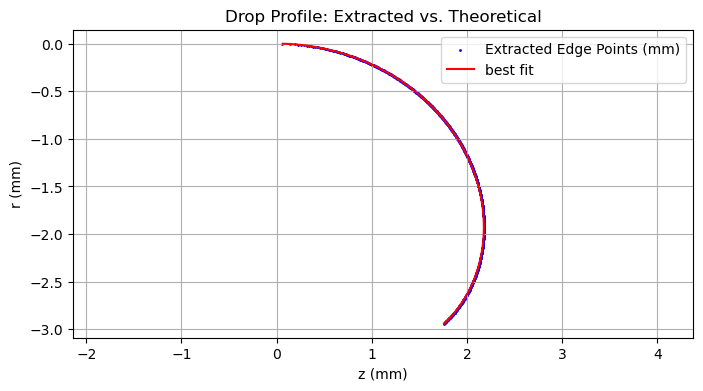

In [146]:
def laplace_residuals(params, z_exp, r_exp):
    
    R0, gamma = params
    
    z_norm, r_norm = normalize_exp_data(R0, z_exp, r_exp)
    r_theor = compute_theoretical_r_profile(R0, gamma, z_norm)
    return (r_theor - r_norm)  # difference between the 


R0_guess = (r_fitted * px_to_mm)*1e-3  # Initial radius of curvature in meters, use fitted value of r
gamma_guess = 85e-3  # Surface tension in N/m
initial_guess = [R0_guess, gamma_guess]
z_exp = final_y_values
r_exp = final_x_values

# Perform least squares fitting
result = least_squares(laplace_residuals, initial_guess, args=(z_exp, r_exp))
R0_fit, gamma_fit = result.x

print (R0_fit, gamma_fit)

z_norm, r_norm = normalize_exp_data(R0_fit, z_exp, r_exp)
r_theor = compute_theoretical_r_profile(R0_fit, gamma_fit, z_norm)

#compare
plt.figure(figsize=(8, 4))
plt.scatter(r_exp,z_exp,  s=1, color='blue', label='Extracted Edge Points (mm)')
plt.plot( r_theor*R0_fit*1e3, -z_norm*R0_fit*1e3,color='red', label='best fit')

# Labels and formatting
plt.xlabel("z (mm)")
plt.ylabel("r (mm)")
plt.title("Drop Profile: Extracted vs. Theoretical")
plt.legend()
plt.axis("equal")  # Maintain aspect ratio
plt.grid()

## Print the Solution

In [134]:
print(f"R0_fit (mm): {R0_fit:.6f}")
print(f"Surface Tension (mJ/m2): {gamma_fit*1000:.6f}")

R0_fit (mm): 0.002412
Surface Tension (mJ/m2): 71.235854
